In [113]:
import numpy as np
import pickle
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import librosa

#### Basic functions to get bootleg scores for MIDI and sheet music.

In [114]:
def loadMidiBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    miditimes = d['times']
    num_notes = np.array(d['num_notes'])
    stafflines = d['stafflines']
    return bscore, miditimes, num_notes, stafflines

In [115]:
def loadSheetBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as f:
        d = pickle.load(f)
    bscore = d['bscore']
    events = d['events']
    return bscore, events

#### Get first or last elements of lines. 

In [116]:
def getBoundaryElements(piece, loc):
    '''
    Variable loc could be either 'F' or 'L'.
    Get all elements that are first or last element of a single line, given a piece number.
    '''
    first = []
    last = []
    with open('/home/mshan/ttemp/data/bscore_sheet/p{}.pkl'.format(piece), 'rb') as pklfile:
        d = pickle.load(pklfile)
        for i in range(1, len(d['events'])):
            
            # check if on the same page as the previous event
            if d['events'][i][2] != d['events'][i-1][2]:
                first.append(i)
                
        for i in range(0, len(d['events'])-1):
            # check if on the same page as the next event
            if d['events'][i][2] != d['events'][i+1][2]:
                last.append(i)
                
    if loc == 'F':
        return [0] + first # 0 is also a first element
    return last + [len(d['events']) - 1] # add the last element of a piece

#### Metric functions taken from previous code

In [117]:
def normalizedCostMetric(Q, R, numQueryNotes, numRefNotes):
    '''
    Take two vectors, return the normalized cost metric by taking dot product and divided by the maximum norm factor.
    '''
    cost = - Q.T @ R
    query_norm_factor = repmat(numQueryNotes.reshape((-1,1)), 1, R.shape[1])
    ref_norm_factor = repmat(numRefNotes.reshape((1,-1)), Q.shape[1], 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-8 # avoid divide by 0
    norm_cost = cost / norm_factor
    return norm_cost

In [118]:
def computeCostMatrix(query, ref, numRefNotes):
    numQueryNotes = np.sum(query, axis=0)
    C = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)
    return C

#### Experiment

In [187]:
piece = 15
midi_pkl_dir = '/home/mshan/ttemp/data/bscore/p15.pkl'
sheet_pkl_dir = '/home/mshan/ttemp/data/bscore_sheet/p15.pkl'
piece_dir = '/home/mshan/ttemp/data/png/p15'

In [188]:
bscore_midi, miditimes, num_midi_notes, stafflines = loadMidiBootlegScore(midi_pkl_dir)
bscore_sheet,events = loadSheetBootlegScore(sheet_pkl_dir)
num_sheet_notes = np.asarray([len(event[0]) for event in events])

#### Run subsequence DTW for each line of music and the whole midi bootleg score. Concatenate and get matrix C. 

In [189]:
steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
weights = [2,1,1]

In [190]:
bscore_midi.shape

(62, 1426)

In [191]:
bscore_sheet.shape

(62, 4202)

In [192]:
def subsequenceDTW(C, steps, weights):
    '''
    Regular subsequence DTW, used to retrieve single line of sheet music from the whole midi.
    Function taken from class homework. 
    '''

    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int16)

    D[0, :] = C[0, :]
    for r in range(1, C.shape[0]):
        for c in range(0, C.shape[1]):
            min_cost = np.inf
            min_idx = -1
            for idx in range(len(steps)):
                r_step, c_step = steps[idx]
                if r >= r_step and c >= c_step:
                    cost = D[(r-r_step, c-c_step)] + C[(r, c)] * weights[idx]
                    if cost < min_cost:
                        min_idx = idx
                        min_cost = cost
            D[(r, c)] = min_cost
            B[(r, c)] = min_idx
            
    lastloc = (D.shape[0] - 1, np.argmin(D[-1, :]))
    path = backtrace(D, B, steps, lastloc)    
    path = np.array(path)
    
    return path, D, B

In [144]:
def backtrace(D, B, steps, lastloc):
    '''
    Regular backtrace. 
    '''

    loc = lastloc
    while loc[0] != 0:
        r, c = loc
        idx = B[(r, c)]
        r_step, c_step = steps[idx]
        loc = (r - r_step, c - c_step)
    
    return loc[1]

In [193]:
num_lines = len(getBoundaryElements(piece, "F"))
# C is the matrix of all last lines
C = np.zeros((num_lines, 1 + bscore_midi.shape[1]))  # leave space to insert filler columns
T = np.zeros((num_lines, bscore_midi.shape[1]), dtype=np.int16)  

for line in range(num_lines):
    # calculate start and end indices for that line
    if line % 10 == 0:
        print('DTW for line {}'.format(line)) 
    start_idx = getBoundaryElements(piece, "F")[line]
    end_idx = getBoundaryElements(piece, "L")[line]
    bscore_line = bscore_sheet[:, start_idx : end_idx + 1]
    
    # dtw
    cost = computeCostMatrix(bscore_line, bscore_midi, num_midi_notes)
    wp, D, B = subsequenceDTW(cost, steps, weights)
    
    # update C
    C[line, 1:] = D[-1, :]
    
    # update T
    for col in range(T.shape[1]):
        # T[(line, col)] is the starting point for C[(line, col)].
        lastloc = (D.shape[0] - 1, col) 
        T[(line, col)] = backtrace(D, B, steps, lastloc)

DTW for line 0
DTW for line 10
DTW for line 20
DTW for line 30
DTW for line 40
DTW for line 50
DTW for line 60
DTW for line 70
DTW for line 80


In [194]:
C.shape

(89, 1427)

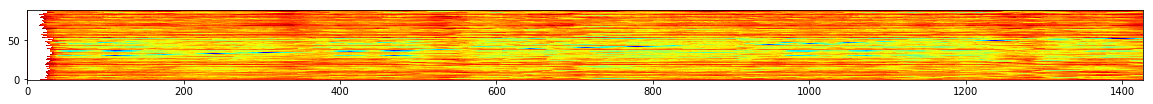

In [195]:
plt.figure(figsize = (20,20))
plt.imshow(C, origin = 'lower', cmap = 'jet')

In [196]:
T.shape
# why some negative values? 
# Doesn't matter, just ignore here.
T[T < 0] = 0

In [197]:
T

array([[   0,    0,    0, ..., 1376, 1376, 1376],
       [   0,    0,    0, ..., 1361, 1361, 1361],
       [   0,    0,    0, ..., 1379, 1379, 1379],
       ...,
       [   0,    0,    0, ..., 1379, 1379, 1379],
       [   0,    0,    0, ..., 1360, 1360, 1360],
       [   0,    0,    0, ..., 1399, 1399, 1399]], dtype=int16)

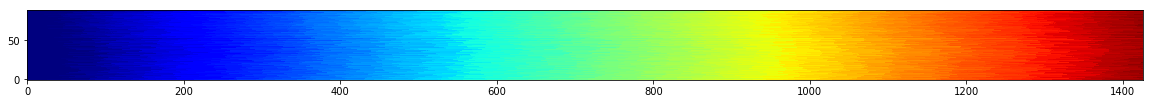

In [198]:
plt.figure(figsize = (20,20))
plt.imshow(T, origin = 'lower', cmap = 'jet')

#### hierarchicalDTW

In [199]:
def backtrace2(DD, BB1, BB2):
    '''
    Take the accumulated cost matrix D, and two helper matrices 
    that record the r_step and c_step that lead to each location in D.
    '''
    path = []
    lastcol = np.argmin(DD[-1, :])
    loc = (DD.shape[0] - 1, lastcol)
    path.append(loc)
    while loc[0] != 0:
        r, c = loc
        r_step = BB1[(r, c)]
        c_step = BB2[(r, c)]
        print(r, r_step, c, c_step, T[(r, c)])
        loc = (r - r_step, c - c_step)
        path.append(loc)
    
    return path

In [200]:
alpha = 0.5

# Name them DD and BB to avoid confusion
DD = np.zeros((C.shape[0], C.shape[1] - 1))
BB1 = np.zeros(DD.shape, dtype=np.int64)  # row jump to this location
BB2 = np.zeros(DD.shape, dtype=np.int64)  # col jump to this location


DD[0, :] = C[0, 1:]  

for r in range(1, DD.shape[0]):
    for c in range(0, DD.shape[1]):
        k = T[(r, c)]
        # jump from (n, k-1) where n = 0, 1, ..., T.shape[0] - 1
        jumpSteps = [(r-n, c-k+1) for n in range(T.shape[0])]
        steps = [(0,1)] + jumpSteps
        weights = [0] + [alpha] * len(jumpSteps)
        weights[r + 1] = 1  # if jumping from (r-1, k-1), weight should be 1
        
        minCost = np.inf
        minIdx = -1
        
        for idx in range(len(steps)):
            r_step, c_step = steps[idx]
            if r >= r_step and c >= c_step and r-r_step < DD.shape[0] and c-c_step < DD.shape[1]:
                cost = DD[(r-r_step, c-c_step)] + C[(r, c + 1)] * weights[idx]
                if cost < minCost:
                    minCost = cost
                    minIdx = idx
                    
        DD[(r, c)] = minCost
        BB1[(r, c)] = steps[minIdx][0]
        BB2[(r, c)] = steps[minIdx][1]
        
wp = backtrace2(DD, BB1, BB2)

/home/mshan/py3env/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


88 36 1425 27 1399
52 0 1398 1 1327
52 0 1397 1 1327
52 0 1396 1 1327
52 0 1395 1 1327
52 0 1394 1 1327
52 0 1393 1 1327
52 0 1392 1 1327
52 0 1391 65 1327
52 0 1326 1 1253
52 0 1325 1 1253
52 0 1324 1 1253
52 0 1323 1 1253
52 0 1322 1 1253
52 0 1321 1 1253
52 0 1320 1 1253
52 0 1319 1 1253
52 0 1318 1 1253
52 0 1317 1 1253
52 0 1316 1 1253
52 0 1315 1 1253
52 0 1314 1 1253
52 2 1313 61 1253
50 0 1252 1 1166
50 0 1251 1 1166
50 0 1250 1 1166
50 0 1249 1 1166
50 0 1248 1 1166
50 0 1247 1 1166
50 0 1246 1 1166
50 0 1245 1 1166
50 0 1244 1 1166
50 0 1243 1 1166
50 0 1242 1 1166
50 0 1241 1 1166
50 0 1240 1 1166
50 0 1239 1 1166
50 0 1238 1 1166
50 0 1237 1 1166
50 0 1236 1 1166
50 0 1235 1 1166
50 0 1234 69 1166
50 0 1165 1 1092
50 0 1164 1 1092
50 0 1163 1 1092
50 0 1162 1 1092
50 0 1161 1 1092
50 0 1160 1 1092
50 0 1159 1 1092
50 0 1158 1 1092
50 0 1157 1 1092
50 0 1156 1 1092
50 0 1155 1 1092
50 0 1154 1 1092
50 0 1153 1 1092
50 0 1152 1 1092
50 0 1151 1 1092
50 0 1150 1 1092
50 0 1149

IndexError: index -1427 is out of bounds for axis 1 with size 1426

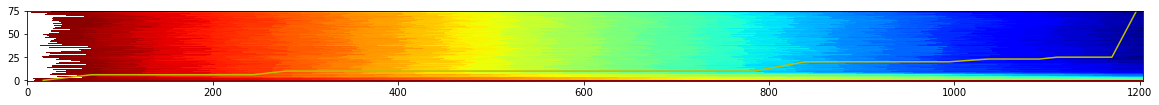

In [186]:
plt.figure(figsize = (20,20))
plt.imshow(DD, origin = 'lower', cmap = 'jet')
plt.plot(wp[:,1], wp[:,0], color='y')

In [185]:
wp = np.array(wp)

In [178]:
wp

[[19, 1196],
 [19, 1195],
 [19, 1194],
 [19, 1193],
 [19, 1192],
 [19, 1191],
 [19, 1190],
 [19, 1189],
 [19, 1188],
 [19, 1187],
 [19, 1186],
 [19, 1185],
 [19, 1184],
 [19, 1183],
 [19, 1182],
 [19, 1181],
 [19, 1180],
 [19, 1136],
 [19, 1135],
 [19, 1134],
 [19, 1133],
 [19, 1132],
 [19, 1087],
 [19, 1086],
 [19, 1085],
 [19, 1084],
 [19, 1040],
 [19, 1039],
 [19, 1038],
 [19, 1037],
 [19, 1036],
 [19, 1035],
 [19, 1034],
 [19, 1033],
 [19, 1032],
 [19, 1031],
 [19, 1030],
 [19, 1029],
 [19, 1028],
 [19, 1027],
 [19, 1026],
 [19, 1025],
 [19, 1024],
 [19, 1023],
 [19, 1022],
 [19, 1021],
 [19, 1020],
 [19, 1019],
 [19, 1018],
 [19, 1017],
 [19, 1016],
 [19, 1015],
 [19, 1014],
 [19, 1013],
 [19, 1012],
 [19, 1011],
 [19, 1010],
 [19, 1009],
 [19, 1008],
 [19, 1007],
 [19, 1006],
 [19, 1005],
 [19, 1004],
 [19, 1003],
 [19, 1002],
 [19, 1001],
 [19, 951],
 [19, 950],
 [19, 949],
 [19, 948],
 [19, 947],
 [19, 946],
 [19, 945],
 [19, 944],
 [19, 891],
 [19, 839],
 [10, 790],
 [10, 789]